In [14]:
%matplotlib inline
# !pip3 install imutils
# !pip3 install scikit-image
# !pip3 install pytesseract
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math
import pytesseract
import re

from functools import partial
import concurrent.futures

In [15]:
%run four_point_transform.py
%run cv_utils/cv_utils.py

<Figure size 432x288 with 0 Axes>

In [16]:
def match_int(s):
    match = re.match('\d+', s)
    if match is None:
        return 0
    return int(match.group(0))

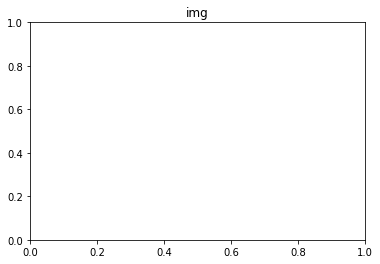

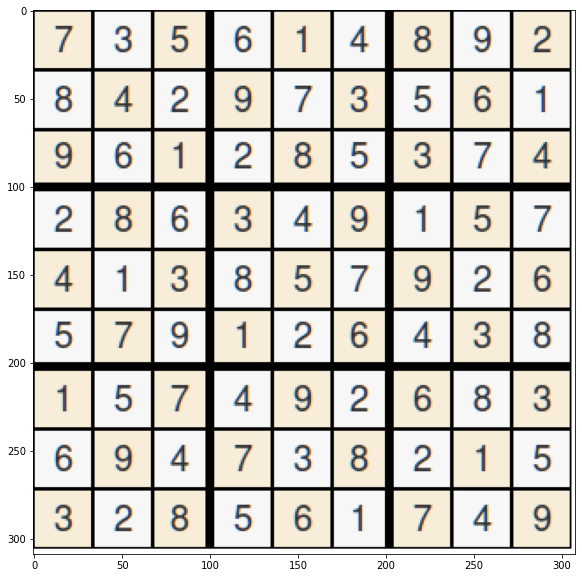

In [35]:
# src = 'sudoku.jpeg'
# src = 'sudoku_1.png'
# src = 'sudoku_2.png'
src = 'sudoku_3.png'

img = cv.imread(src)

draw(img)

In [36]:
class Pipeline:
    def __init__(self, pipelines):
        self.pipelines = pipelines
    def exec(self, src):
        dst = src.copy()
        self.steps = {}
        for name, fn in self.pipelines:
            dst = fn(dst)
            self.steps[name] = dst.copy()
        return dst

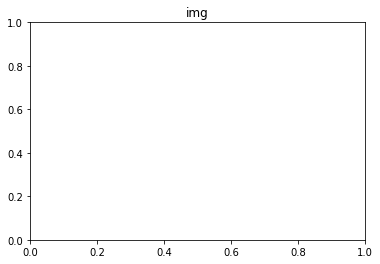

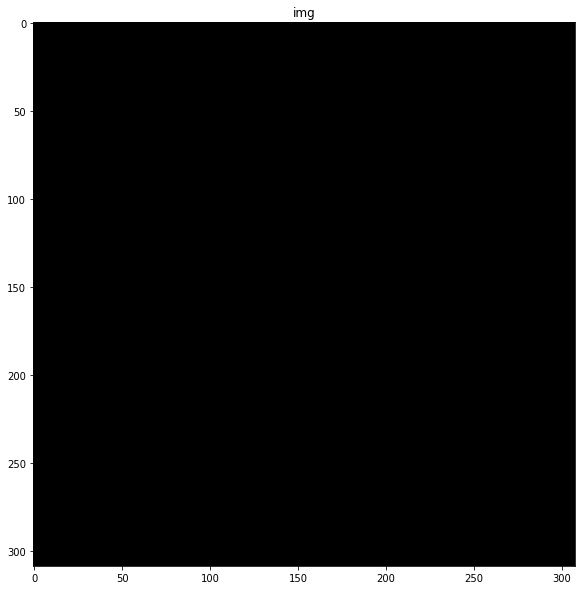

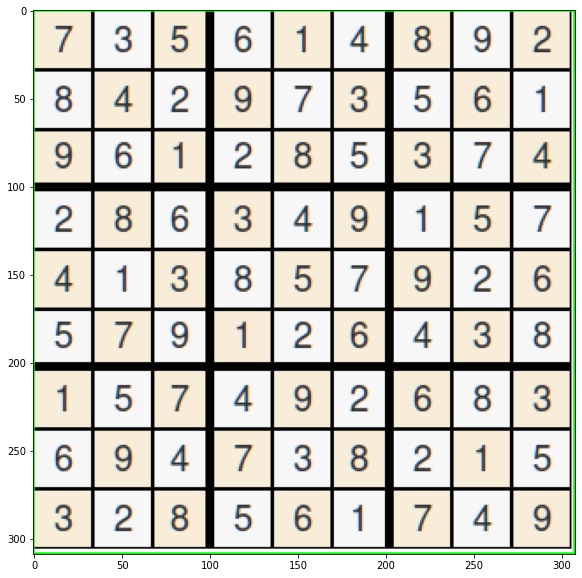

In [37]:
height, width = img.shape[:2]

# Assuming user takes the full photo of sudoku - so the whole grid fits into
# the picture. Since it's a square, take the minimum dimension. 
# Assume that the box fit to at least 80% of the image (the Pareto's Principle).
dim = min(height, width) * 0.8


# Divide it by 9 since one row/column will have 9 cells. 
# Use that as the kernel size.
cell = int(dim / 9) # Equivalent to math.ceil.

pipeline = Pipeline([('gray', Gray),
                     ('inverse', Inverse),
#                      ('blur', MedianBlur),
                     # We want to use tophat to capture only the grid - 
                     # anything larger than it will be excluded.
                     ('tophat', partial(TopHat, size=(cell, cell))),
                     ('thresh', Otsu),
                     ('floodfill', partial(FloodFill, color=255))
                    ])

dst = pipeline.exec(img)
draw(dst)
# Find the largest contour on the image. This represents the sudoku main grid.
cnt = FindOuterContour(dst)
DrawContour(img, [cnt])

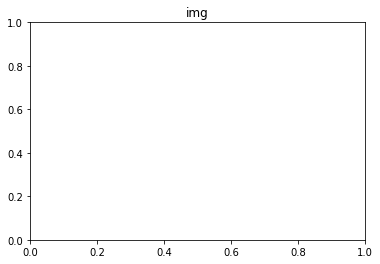

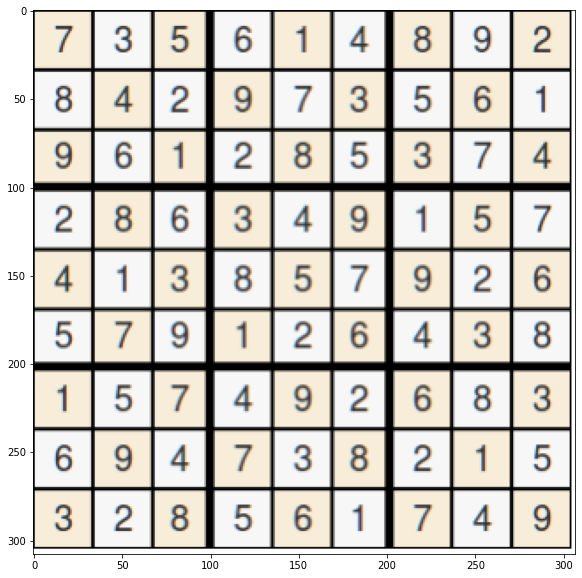

In [38]:
# The image may be skewed, we will correct it.
transform = four_point_transform(img.copy(), cnt.reshape(4, 2))
draw(transform)

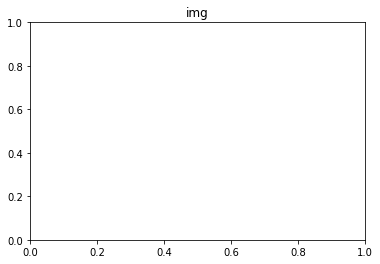

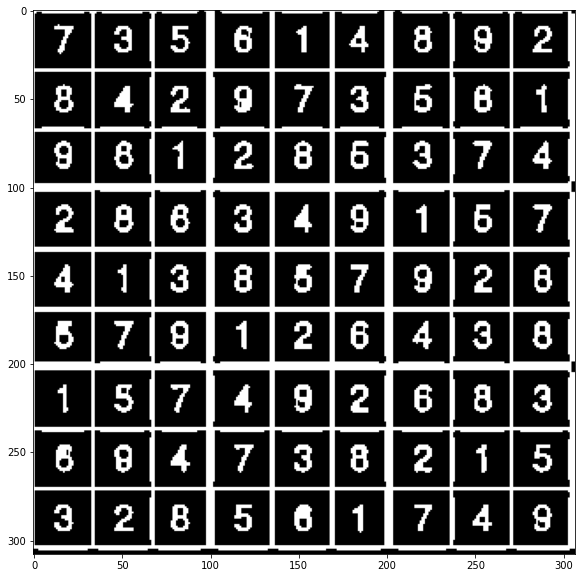

In [39]:
im_shift = cv.pyrMeanShiftFiltering(transform, 3, 9)
im_gray = Gray(im_shift)

im_blur = GaussianBlur(im_gray)
im_thresh = AdaptiveThreshold(im_blur)

# Fix vertical grid.
im_morph = Close(im_thresh, kernel=cv.getStructuringElement(cv.MORPH_CROSS, (3, 1))) 

# Fix horizontal grid.
im_morph = Close(im_morph, kernel=cv.getStructuringElement(cv.MORPH_CROSS, (1, 3)))

# cnt = FindOuterContour(im_tophat)
# DrawContour(transform, [cnt])
draw(im_morph)

In [40]:
height, width = transform.shape[:2]
cell_height, cell_width = height//9, width//9
offset_height, offset_width = cell_height // 5, cell_width // 5
print('offset_height:', offset_height)
print('offset_width:', offset_width)
dim = min(cell_width, cell_height)

sudoku = np.zeros((9, 9), int)

# Get the image from left to right, top to bottom.
for i in range (0, 9):
    for j in range (0, 9):
        label = f'i: {i}, j: {j}'
        # We do not take the extra square, but instead allow padding of 20% on the left, right, top and bottom.
        y0, y1 = max(i * cell_height - offset_height, 0), min((i+1) * cell_height + offset_height, height)
        x0, x1 = max(j * cell_width - offset_width, 0), min((j+1) * cell_width + offset_width, width)
        
        # Note that height comes before width.
        im_clip = im_morph[:][y0:y1, x0:x1]
        
        bordersize = 1
        im_clip = cv.copyMakeBorder(
            im_clip,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv.BORDER_CONSTANT,
            value=[255, 255, 255]
        )

        im_roi = Fill(im_clip, color=(0, 0, 0))
        im_roi = Open(im_roi, size=(2, 2))
        
        # Make the foreground (text) black, and background white.
        im_roi = Inverse(im_roi)
#         draw(im_roi, label)
        
        # If all the color is the same as the first color, it means the box is empty.
        result = np.all(im_roi == im_roi[0])
        if result:
            continue

        try:
            text = pytesseract.image_to_string(im_roi, config='--oem 1 --psm 6 -c tessedit_char_whitelist=0123456789') # Needs to be enabled to read single digit.
            sudoku[i, j] = match_int(text)
        except:
            continue
sudoku

offset_height: 6
offset_width: 6


array([[7, 3, 5, 6, 1, 4, 8, 9, 2],
       [8, 4, 2, 0, 7, 3, 5, 8, 1],
       [9, 8, 1, 2, 8, 6, 3, 7, 4],
       [2, 8, 6, 3, 4, 9, 1, 6, 7],
       [4, 1, 3, 8, 5, 7, 9, 2, 8],
       [6, 7, 9, 1, 2, 6, 4, 3, 8],
       [1, 5, 7, 4, 9, 2, 6, 8, 3],
       [6, 9, 4, 7, 3, 8, 2, 1, 5],
       [3, 2, 8, 5, 0, 1, 7, 4, 9]])

In [41]:
%run sudoku.py

<Figure size 432x288 with 0 Axes>

In [42]:
solver = SudokuSolver()
result = solver(sudoku)
print(result)

None


In [43]:
font = cv.FONT_HERSHEY_SIMPLEX

color = (0, 255, 0) 
thickness = 2

def get_optimal_font_scale(text, width):
    for scale in reversed(range(0, 60, 1)):
        textSize = cv.getTextSize(text, fontFace=cv.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if new_width <= width:
            return scale/10
    return 1


im_gray = cv.bitwise_not(Gray(transform))
im_out = cv.cvtColor(im_gray, cv.COLOR_GRAY2RGB)

height, width = transform.shape[:2]
cell_height, cell_width = height // 9, width // 9

for i in range(0, 9):
    for j in range(0, 9):
        point = (cell_width * i, cell_height * (j+1))
        text = str(int(result[j, i]))
        font_scale = get_optimal_font_scale(text, cell_width)
        if sudoku[j, i] == 0:
            im_out = cv.putText(im_out, text, point, font, font_scale, color, thickness, cv.LINE_AA) 
        else:
            im_out = cv.putText(im_out, text, point, font, font_scale, (255, 0, 0), thickness, cv.LINE_AA) 
draw(im_out)

TypeError: 'NoneType' object is not subscriptable